Observatory Charts Demonstration Notebook
==========

This is a brief how to and practical documentation for the Academic Observatory analysis and charting library. For
full documentation of the API see ReadTheDocs.

In [1]:
import os
import pathlib

from academic_observatory.reports import *
from academic_observatory.reports.charts import *

sns.set_context('paper')

In [2]:
# The test data files that you can use are in academic-observatory/tests/data/reports. The below assumes that
# you are running this notebook from academic-observatory/notebooks
test_data_file = os.path.join(pathlib.Path().absolute().parent, 'tests', 'fixtures', 'reports', 'test_oa_data.csv')
df = pd.read_csv(test_data_file)

# This data comes from Huang et al (2020), https://doi.org/10.1101/2020.03.19.998336 and the full data
# set can be found at https://doi.org/10.5281/zenodo.3693221
paperdata = pd.read_csv(
    'https://zenodo.org/record/3693222/files/institutional_oa_evaluation_2020_named_unis_dataset_2020_02_12.csv?download=1')

Structure of the data
------------------------

The chart library makes a series of assumptions about the availability of columns in the data. These are generally
achieved by running a series of helpers over a dataset that is pulled from the observatory.academy datastore via a
standard method.

The helpers calculate percentages over several columns and can also be used for error calculations that are important
for some graphs. Most importantly it provides a series of nicer formatted names for graph axes and plots more generally.
The test data here has already been processed through these helpers. The helpers are available through the
academic-observatory.reports module but are reproduced here for completeness in the collapsed cell just above
 `The Charts`.

In [3]:
df.columns

Index(['Unnamed: 0', 'id', 'name', 'country', 'country_code', 'region',
       'subregion', 'published_year', 'total', 'total_oa', 'green', 'gold',
       'gold_just_doaj', 'hybrid', 'bronze', 'green_only',
       'green_in_home_repo', 'total_citations', 'cited_articles',
       'oa_citations', 'gold_citations', 'green_citations', 'hybrid_citations',
       'percent_total_oa', 'percent_green', 'percent_gold', 'percent_hybrid',
       'percent_bronze', 'percent_gold_just_doaj', 'percent_green_only',
       'percent_total_oa_err', 'percent_green_err', 'percent_gold_err',
       'Open Access (%)', 'Total Green OA (%)', 'Total Gold OA (%)',
       'Gold in DOAJ (%)', 'Hybrid OA (%)', 'Bronze (%)', 'Green Only (%)',
       'Total Publications', 'Year of Publication', 'University Name',
       'Region', 'Country', 'Citation Count', 'Cited Articles',
       'Citations to OA Outputs', 'Citations to Gold Outputs',
       'Citations to Green Outputs', 'Citations to Hybrid Outputs',
       'Total

In [4]:
def clean_geo_names(df: pd.DataFrame) -> pd.DataFrame:
    """Convenience function for standardising country names

    The input country names can be quite long and for our purposes we want to
    separate Mexico from the rest of North America and treat it as part of
    Latin America. This function cleans up and shortens some specific country
    names (which are defined in the `country_clean` dict in the defaults
    module) and the region names.

    :param df: Input data frame to be cleaned up
    :type df: pandas DataFrame
    :return: DataFrame with country and region  names cleaned up.
    :rtype: pandas DataFrame
    """

    df.replace(to_replace=country_clean, inplace=True)

    df.loc[df.country.isin(
        ['Canada', 'United States of America']), 'region'] = 'North America'
    df.replace('Americas', 'Latin America', inplace=True)
    return df


def clean_output_type_names(df: pd.DataFrame) -> pd.DataFrame:
    """Convenience function for cleaning up output type names

    The `outputs_clean` dict is located in the defaults submodule

    :param df: Input data frame to be cleaned up
    :type df: pandas DataFrame
    :return: DataFrame with output type names cleaned up.
    :rtype: pandas DataFrame
    """
    df.replace(to_replace=outputs_clean, inplace=True)
    return df


def nice_column_names(df):
    """Convert standard BQ names to nice names for plotting"""

    cols = [
        ('Open Access (%)', 'percent_OA'),
        ('Open Access (%)', 'percent_oa'),
        ('Open Access (%)', 'percent_total_oa'),
        ('Total Green OA (%)', 'percent_green'),
        ('Total Gold OA (%)', 'percent_gold'),
        ('Gold in DOAJ (%)', 'percent_gold_just_doaj'),
        ('Hybrid OA (%)', 'percent_hybrid'),
        ('Bronze (%)', 'percent_bronze'),
        ('Total Green OA (%)', 'percent_green'),
        ('Green Only (%)', 'percent_green_only'),
        ('Green in IR (%)',
         'percent_green_in_home_repo'),
        ('Total Publications', 'total'),
        ('Change in Open Access (%)', 'total_oa_pc_change'),
        ('Change in Green OA (%)', 'green_pc_change'),
        ('Change in Gold OA (%)', 'gold_pc_change'),
        ('Change in Total Publications (%)', 'total_pc_change'),
        ('Year of Publication', 'published_year'),
        ('University Name', 'name'),
        ('Region', 'region'),
        ('Country', 'country'),
        ('Citation Count', 'total_citations'),
        ('Cited Articles', 'cited_articles'),
        ('Citations to OA Outputs', 'oa_citations'),
        ('Citations to Gold Outputs', 'gold_citations'),
        ('Citations to Green Outputs', 'green_citations'),
        ('Citations to Hybrid Outputs', 'hybrid_citations'),
        ('Total Outputs', 'total'),
        ('Journal Articles', 'journal_articles'),
        ('Proceedings', 'proceedings_articles'),
        ('Books', 'authored_books'),
        ('Book Sections', 'book_sections'),
        ('Edited Volumes', 'edited_volumes'),
        ('Reports‡', 'reports'),
        ('Datasets‡', 'datasets')
    ]
    for col in cols:
        if col[1] in df.columns.values:
            df[col[0]] = df[col[1]]

    return df

paperdata = clean_geo_names(paperdata)
paperdata = nice_column_names(paperdata)

The Charts
-------------

All charts have an initialisation method, a method for processing data to reshape and filter, and a plotting method.
The plotting methods will generally accept keyword arguments for the underlying plot type (from Seaborn or Matplotlib).
The parameters for plotting are provided in the instantiation step.

### Scatter Plot
The scatter plot provides a means of creating a an x-y plot in which each organisation or unit of analysis is plotted.
Internally it uses the Seaborn scatterplot method. This provides automatic colouring and sizing of points to highlight
distributions. A specific ID can be selected to be highlighted using a cross.

Initialisation variables are:
* df: A pandas DataFrame
* x: The column with x-values
* y: The column with y-values
* filter_name: The name of a column to (optionally) filter on (often `published_year`)
* filter_value: The value to filter for (often a specific year). Can be a value or a list.
* hue_column: The name of the column to use to assign hue (defaults to `region`)
* size_column: The name of the column to use to assign point size (defaults to `total`)

/home/jamie/workspaces/coki_workspace/academic-observatory/venv/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jamie/workspaces/coki_workspace/academic-observatory/venv/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


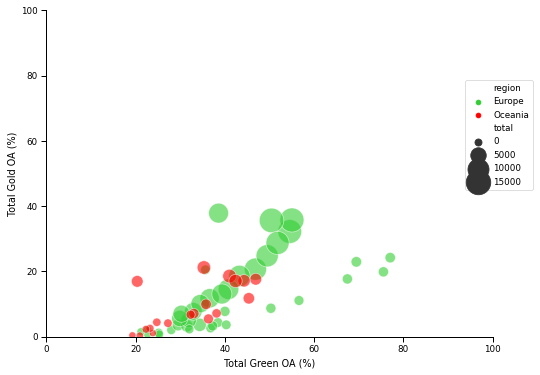

In [5]:
scatter = ScatterPlot(df, 
                      x='Total Green OA (%)', 
                      y='Total Gold OA (%)', 
                      filter_name='region',
                      filter_value=['Europe','Oceania'])
scatter.process_data()
scatter.plot(xlim=(0,100), ylim=(0,100), figsize=(8,6));

The results are more interesting for a single year in a larger dataset

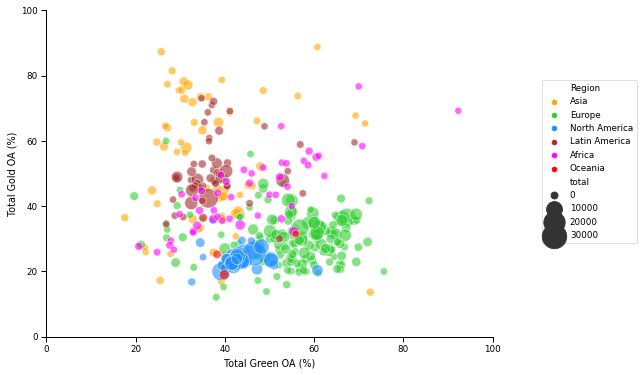

In [6]:
scatter = ScatterPlot(paperdata, 
                      x='Total Green OA (%)', 
                      y='Total Gold OA (%)', 
                      filter_name='published_year',
                      filter_value=2018,
                      hue_column='Region')
scatter.process_data()
scatter.plot(xlim=(0,100), ylim=(0,100), figsize=(8,6));

### TimePlot

TimePlot is a method for showing a linegraph over time for multiple organisations (units of analysis). It plots these
vertically.

* df: pd.DataFrame, DataFrame to plot
* year_range: tuple, with two members to create a range of years (the second year is not included)
* unis: list of institutional identifiers appropriate to the data table
* plot_column: str, name of the column to plot
* hue_column: str = 'name', Not currently used
* size_column: str = None, Not currently used

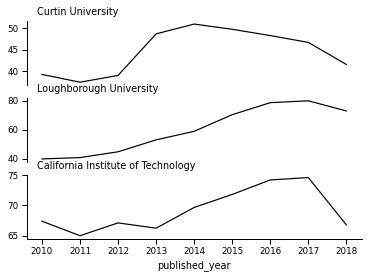

In [7]:
timeplot = TimePlot(df,
                    (2010, 2019),
                    ['grid.1032.0', 'grid.6571.5', 'grid.20861.3d'],
                    'Open Access (%)')
timeplot.process_data()
timeplot.plot();

### A TimePlotLayout is a convenience method for laying out a series of TimePlots into a figure

* df: pd.DataFrame
* plots: dict as below

The plots parameter wraps the extra parameters from TimePlot as follows for each desired panel

{

    year_range: (2010, 2018),
            # A tuple with two elements containing a start and end year
    y_column: 'Total Gold OA (%)
            # A str containing a column name with y values
    unis: ['id1', 'id2', 'id3']
            # An ordered list of identifiers for plotting
    markerline: optional parameter with an int for a year to be marked
}

The `plot` method has some additional parameters for finetuning the layout:
* ylabel_adjustment = 0.025,adjusts horizontal position of the y-axis labels
* panel_labels = False, if True, adds letters to the panels
* panellable_adjustment = 0.01, adjust vertical position of the letters

The plot method returns the matplotlib figure so other adjustments are available via standard matplotlib commands,
including manipulating the y-axis ranges. It also takes keywords for the underlying matplotlib commands to make the
figure and the gridlayout.

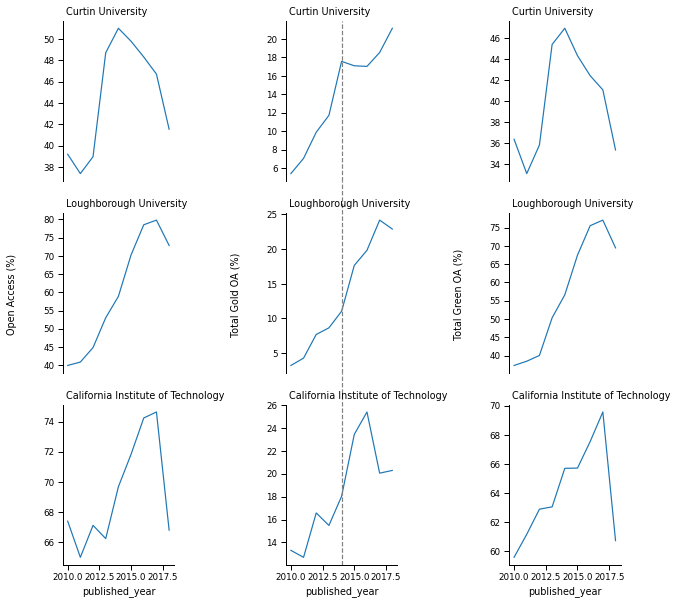

In [8]:
timeplotlayout = TimePlotLayout(df,
                                [
                                    {'year_range': (2010, 2019),
                                     'y_column': 'Open Access (%)',
                                     'unis': ['grid.1032.0', 'grid.6571.5', 'grid.20861.3d']},
                                    {'year_range': (2010, 2019),
                                     'y_column': 'Total Gold OA (%)',
                                     'unis': ['grid.1032.0', 'grid.6571.5', 'grid.20861.3d'],
                                     'markerline': 2014},
                                    {'year_range': (2010, 2019),
                                     'y_column': 'Total Green OA (%)',
                                     'unis': ['grid.1032.0', 'grid.6571.5', 'grid.20861.3d']},
                                ])
timeplotlayout.process_data()
fig = timeplotlayout.plot(ylabel_adjustment=0.07, figsize=(10,10), wspace=1, hspace=1.5)

### TimePath

A TimePath is a way of showing the evolution of a set of organisations over time. It takes similar parameters to a
ScatterPlot but with a list of organisation (or unit of analysis) IDs.

* df: pd.DataFrame,
* year_range: tuple,
* unis: list,
* x: str, column name for x-values
* y: str, column name for y-values
* hue_column: str = 'name',
* size_column: str = None

/home/jamie/workspaces/coki_workspace/academic-observatory/academic_observatory/reports/charts/time_path.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda v: self.unis.index(v))


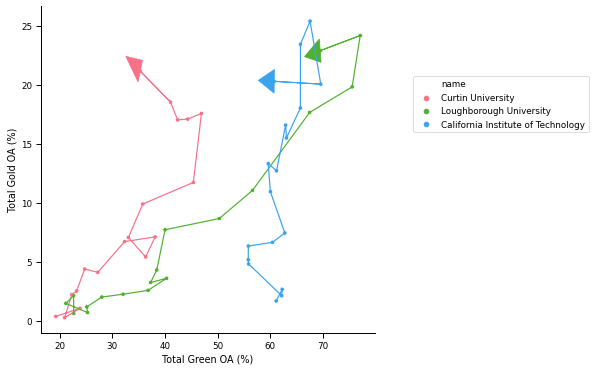

In [9]:
timepath = TimePath(df,
                    (2000, 2019),
                    ['grid.1032.0', 'grid.6571.5', 'grid.20861.3d'],
                    'Total Green OA (%)',
                    'Total Gold OA (%)')
timepath.process_data()
timepath.plot(figsize=(6,6));

## Rankings

Rankings generally show some kind of relationship that is quantitative. These examples are limited because the test
dataset is relatively small.

### RankChart

A rankchart links a position in a ranking based on a variable to the value of that variable. It is helpful in showing
different ranking positions do (or do not) relate to significant differences in the variable being ranked.

It is passed a DataFrame, a column to rank on, a column to filter on (generally a single year) and the value to be
filtered for.

/home/jamie/workspaces/coki_workspace/academic-observatory/academic_observatory/reports/charts/rank_chart.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  left_yaxis.set_yticklabels(left_labels)


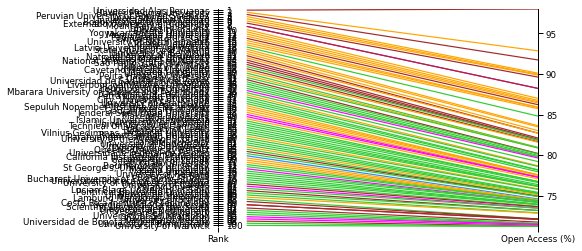

In [10]:
rank = RankChart(paperdata, 'Open Access (%)','Year of Publication', 2017)
rank.process_data()
rank.plot(figsize=(10,3));

### Layouts

Rankings are most commonly presented as Layouts with multiple rankings next to each other for comparison. Layouts take
a dictionary of parameters for each of the charts to be presented in the Layout.

/home/jamie/workspaces/coki_workspace/academic-observatory/academic_observatory/reports/charts/rank_chart.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  left_yaxis.set_yticklabels(left_labels)
/home/jamie/workspaces/coki_workspace/academic-observatory/academic_observatory/reports/charts/rank_chart.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  left_yaxis.set_yticklabels(left_labels)
/home/jamie/workspaces/coki_workspace/academic-observatory/academic_observatory/reports/charts/rank_chart.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  left_yaxis.set_yticklabels(left_labels)


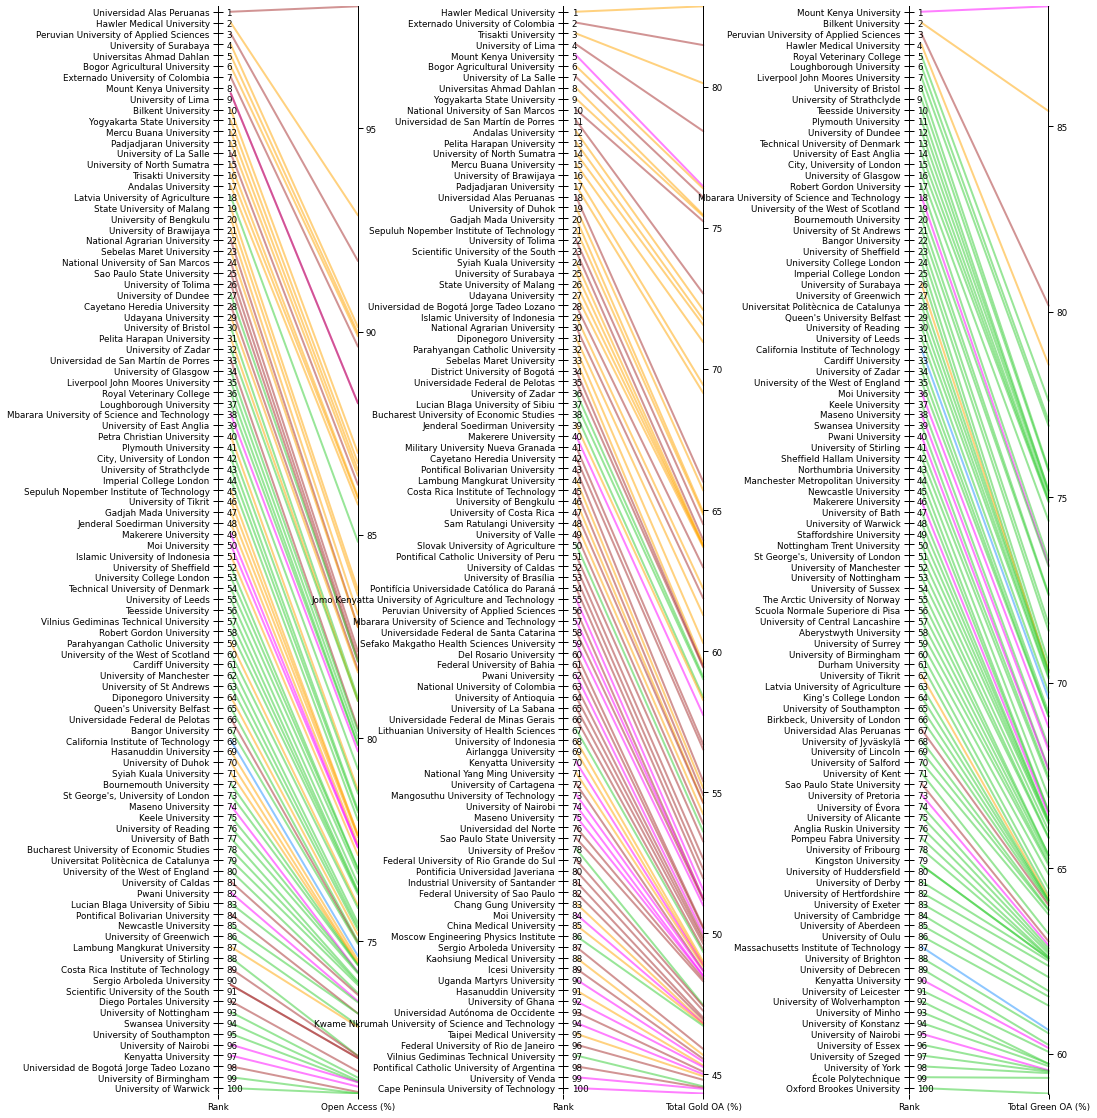

In [11]:
params = [
            {
            'chart_class': RankChart,
            'rankcol': 'Open Access (%)',
            'filter_name': 'Year of Publication',
            'filter_value': 2017
            },
            {
            'chart_class': RankChart,
            'rankcol': 'Total Gold OA (%)',
            'filter_name': 'Year of Publication',
            'filter_value': 2017
            },
            {
            'chart_class': RankChart,
            'rankcol': 'Total Green OA (%)',
            'filter_name': 'Year of Publication',
            'filter_value': 2017
            }
]
ranking = Layout(paperdata, params)
ranking.process_data()
r = ranking.plot(wspace=1.36, line_args={"linewidth": 2, "alpha": 0.5})

### ConfidenceIntervalRank

The ConfidenceIntervalRank chart plots a ranking against the ranked variable with calculated confidence intervals also
included. The confidence intervals need to be calculated.
See [Huang et al. (2020)](https://doi.org/10.1101/2020.03.19.998542) for a discussion of the calculation of confidence
intervals

In [12]:
# calculate the % error margins for 95% confidence intervals for total OA, gold OA and green OA

df['percent_oa_err'] = 100*1.96*(df['percent_total_oa']/100*(1-df['percent_total_oa']/100)/df['total'])**(.5)
df['percent_gold_err'] = 100*1.96*(df['percent_gold']/100*(1-df['percent_gold']/100)/df['total'])**(.5)
df['percent_green_err'] = 100*1.96*(df['percent_green']/100*(1-df['percent_green']/100)/df['total'])**(.5)

The chart method requires the name of the column to be ranked as well as the column containing the error values.

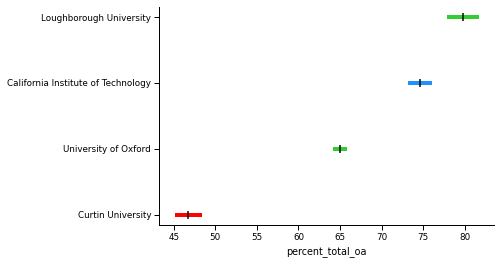

In [13]:
c = ConfidenceIntervalRank(df, 'percent_total_oa', 'percent_oa_err', 'published_year', 2017)
c.process_data()
c.plot();

Again, these charts will mostly be presented in layouts with multiple rankings. The layout defaults are for long tall
layouts which are appropriate when there are more universities in the ranking.

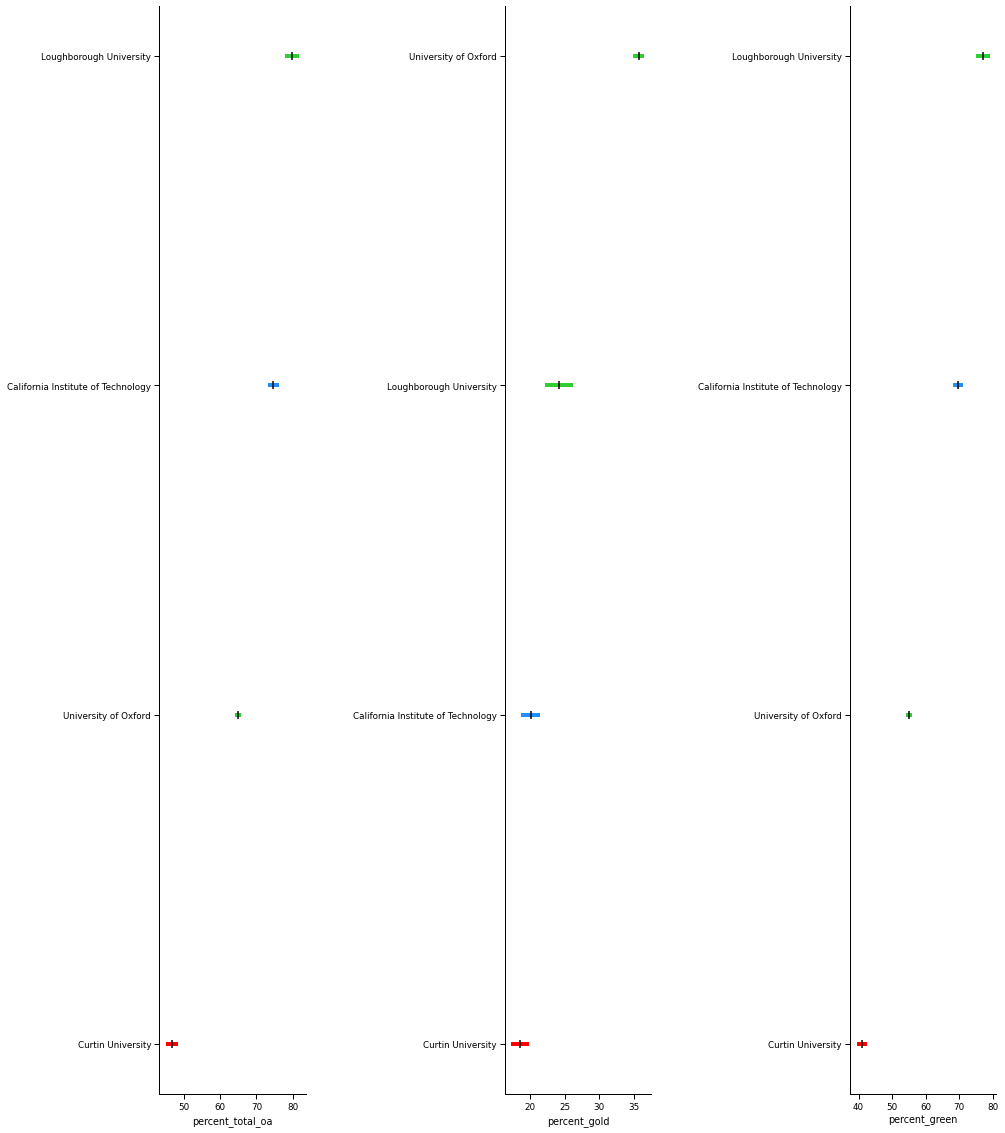

In [14]:
params = [
            {
            'chart_class': ConfidenceIntervalRank,
            'rankcol': 'percent_total_oa',
            'errorcol': 'percent_oa_err',
            'filter_name': 'published_year',
            'filter_value': 2017
            },
            {
            'chart_class': ConfidenceIntervalRank,
            'rankcol': 'percent_gold',
            'errorcol': 'percent_gold_err',
            'filter_name': 'published_year',
            'filter_value': 2017
            },
            {
            'chart_class': ConfidenceIntervalRank,
            'rankcol': 'percent_green',
            'errorcol': 'percent_green_err',
            'filter_name': 'published_year',
            'filter_value': 2017
            }
]
ci = Layout(df, params)
ci.process_data()
ci = ci.plot(wspace=1.36);

### BoxScatter Plot

The box scatter plot is intended to examine differences at various levels of aggregation. The BoxScatter method takes a
dataframe, year of interest, level of aggregation and a list of variables to plot. The vertical order of plotting is
set on the first column and colors default to the region coloring scheme.

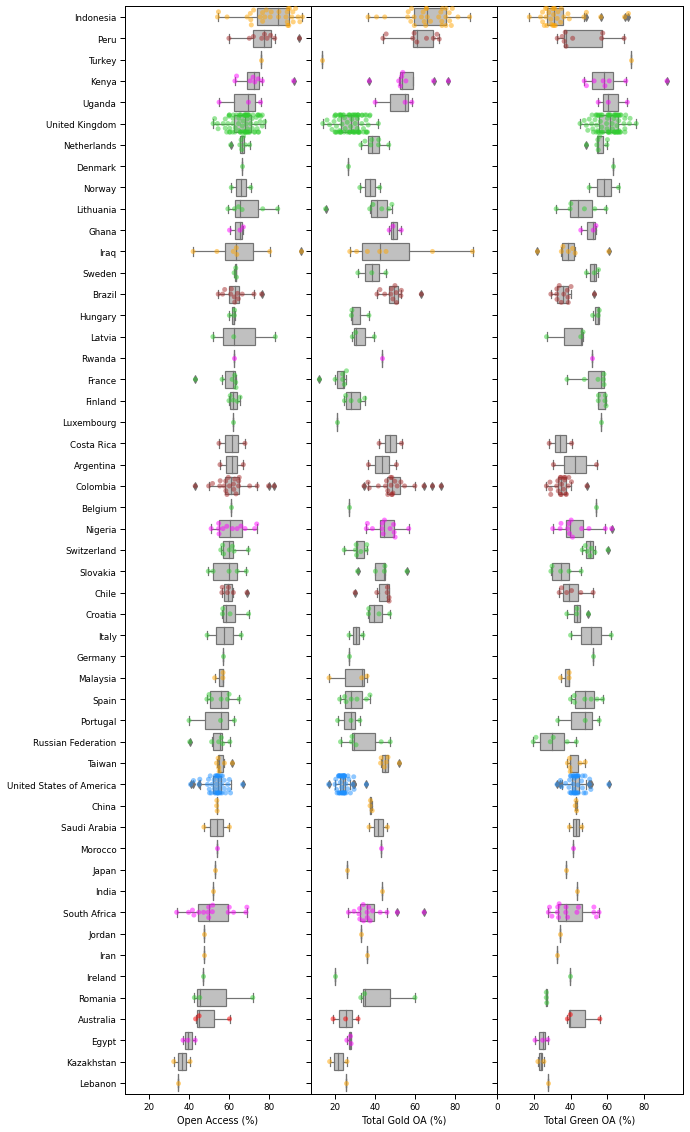

In [15]:
b = BoxScatter(paperdata, 2018, 'country', ['Open Access (%)', 'Total Gold OA (%)','Total Green OA (%)'])
b.process_data()
b.plot(figsize=(10,20));

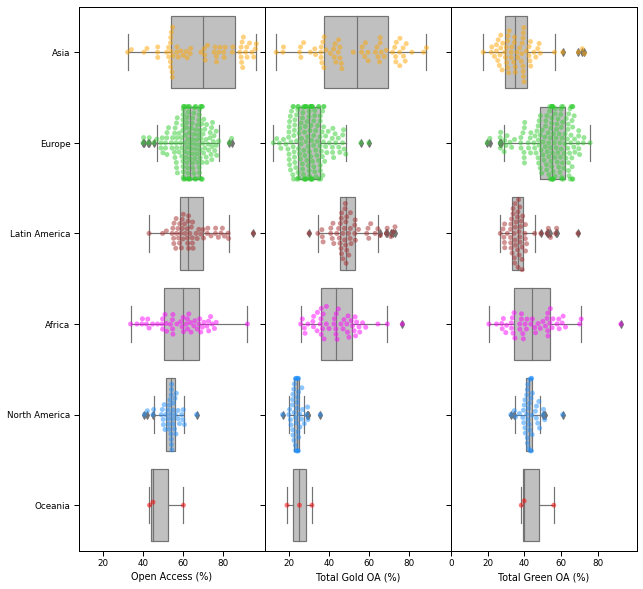

In [16]:
b = BoxScatter(paperdata, 2018, 'region', ['Open Access (%)', 'Total Gold OA (%)','Total Green OA (%)'])
b.process_data()
b.plot(figsize=(10,10));